<a href="https://colab.research.google.com/github/visith1577/Machine-learning-first-projects/blob/main/imdb_multi_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLSFR9O/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLSFR9O/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLSFR9O/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s, l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())

for s, l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)    

In [4]:
vocab_size = 1000
embed_dim = 32
maxlen = 120
oov_token = "<OOV>"
trunc_type = "post"
pad_type = 'post'

from tensorflow.keras.preprocessing.text import  Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=maxlen, truncating=trunc_type,
                       #pad_type=pad_type
                       )

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
padded_test_seq = pad_sequences(testing_sequences, maxlen=maxlen)

In [5]:
reverse_word_dict = dict([(value, key) for (key, value) in word_index.items()])

def decode(text):
  return " ".join([reverse_word_dict.get(i, '?') for i in text])

print(decode(padded[1]))
print(training_sentences[1])  

? ? ? ? ? ? ? b'i have been known to fall <OOV> during films but this is usually due to a <OOV> of things including really <OOV> being <OOV> and <OOV> on the <OOV> and having just <OOV> a lot however on this <OOV> i <OOV> <OOV> because the film was <OOV> the plot development was <OOV> <OOV> slow and boring things seemed to happen but with no <OOV> of what was <OOV> them or why i admit i may have <OOV> part of the film but i watched the <OOV> of it and everything just seemed to happen of its own <OOV> without any real <OOV> for anything else i <OOV> recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit,

In [6]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=maxlen),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 32)           32000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 49,037
Trainable params: 49,037
Non-trainable params: 0
_________________________________________________________________


In [7]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(padded_test_seq, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 22s 16ms/step - loss: 0.6233 - accuracy: 0.6320 - val_loss: 0.4409 - val_accuracy: 0.8043
Epoch 2/50
782/782 [==============================] - 12s 16ms/step - loss: 0.4375 - accuracy: 0.8076 - val_loss: 0.3846 - val_accuracy: 0.8267
Epoch 3/50
782/782 [==============================] - 12s 16ms/step - loss: 0.4151 - accuracy: 0.8122 - val_loss: 0.3889 - val_accuracy: 0.8268
Epoch 4/50
782/782 [==============================] - 12s 16ms/step - loss: 0.3936 - accuracy: 0.8229 - val_loss: 0.3803 - val_accuracy: 0.8281
Epoch 5/50
782/782 [==============================] - 13s 16ms/step - loss: 0.3828 - accuracy: 0.8260 - val_loss: 0.4245 - val_accuracy: 0.8202
Epoch 6/50
782/782 [==============================] - 12s 16ms/step - loss: 0.3688 - accuracy: 0.8388 - val_loss: 0.3919 - val_accuracy: 0.8286
Epoch 7/50
782/782 [==============================] - 12s 16ms/step - loss: 0.3504 - accuracy: 0.8444 - val_loss: 0.3813 - val_accuracy:

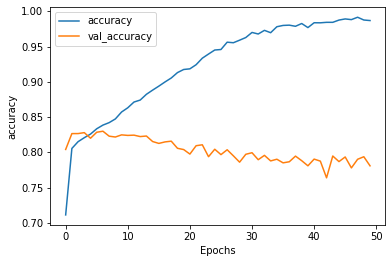

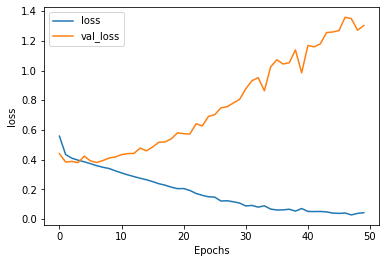

In [8]:

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [9]:
model2 = tf.keras.Sequential([
                              tf.keras.layers.Embedding(vocab_size, embed_dim, input_length = maxlen),
                              tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
                              tf.keras.layers.Dense(6, activation='relu'),
                              tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 32)           32000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12672     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 45,069
Trainable params: 45,069
Non-trainable params: 0
_________________________________________________________________


In [10]:
history2 = model2.fit(
    padded, training_labels_final, epochs=num_epochs, validation_data=(padded_test_seq, testing_labels_final)
)

Epoch 1/50
782/782 [==============================] - 15s 16ms/step - loss: 0.6123 - accuracy: 0.6302 - val_loss: 0.4257 - val_accuracy: 0.8063
Epoch 2/50
782/782 [==============================] - 12s 15ms/step - loss: 0.4211 - accuracy: 0.8078 - val_loss: 0.3771 - val_accuracy: 0.8306
Epoch 3/50
782/782 [==============================] - 12s 15ms/step - loss: 0.3929 - accuracy: 0.8212 - val_loss: 0.3673 - val_accuracy: 0.8347
Epoch 4/50
782/782 [==============================] - 12s 15ms/step - loss: 0.3629 - accuracy: 0.8412 - val_loss: 0.3571 - val_accuracy: 0.8388
Epoch 5/50
782/782 [==============================] - 12s 15ms/step - loss: 0.3439 - accuracy: 0.8481 - val_loss: 0.3692 - val_accuracy: 0.8342
Epoch 6/50
782/782 [==============================] - 11s 14ms/step - loss: 0.3265 - accuracy: 0.8568 - val_loss: 0.3597 - val_accuracy: 0.8399
Epoch 7/50
782/782 [==============================] - 12s 15ms/step - loss: 0.3085 - accuracy: 0.8647 - val_loss: 0.3656 - val_accuracy:

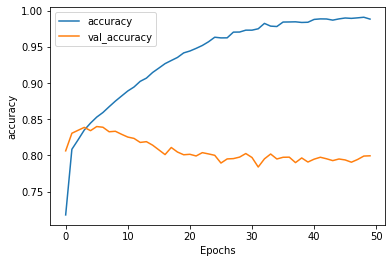

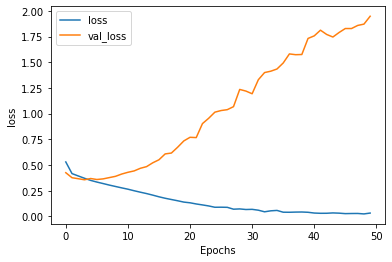

In [11]:
plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')

In [14]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=maxlen),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 32)           32000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 49,037
Trainable params: 49,037
Non-trainable params: 0
_________________________________________________________________


In [15]:
history3 = model3.fit(
    padded, training_labels_final, epochs=num_epochs, validation_data=(padded_test_seq, testing_labels_final)
)

Epoch 1/50
782/782 [==============================] - 6s 6ms/step - loss: 0.5780 - accuracy: 0.6619 - val_loss: 0.3867 - val_accuracy: 0.8234
Epoch 2/50
782/782 [==============================] - 5s 6ms/step - loss: 0.4022 - accuracy: 0.8186 - val_loss: 0.3735 - val_accuracy: 0.8302
Epoch 3/50
782/782 [==============================] - 5s 6ms/step - loss: 0.3842 - accuracy: 0.8257 - val_loss: 0.3693 - val_accuracy: 0.8315
Epoch 4/50
782/782 [==============================] - 5s 6ms/step - loss: 0.3786 - accuracy: 0.8286 - val_loss: 0.3654 - val_accuracy: 0.8346
Epoch 5/50
782/782 [==============================] - 5s 6ms/step - loss: 0.3685 - accuracy: 0.8335 - val_loss: 0.3642 - val_accuracy: 0.8354
Epoch 6/50
782/782 [==============================] - 5s 6ms/step - loss: 0.3604 - accuracy: 0.8399 - val_loss: 0.3756 - val_accuracy: 0.8308
Epoch 7/50
782/782 [==============================] - 5s 6ms/step - loss: 0.3567 - accuracy: 0.8389 - val_loss: 0.3752 - val_accuracy: 0.8298
Epoch 

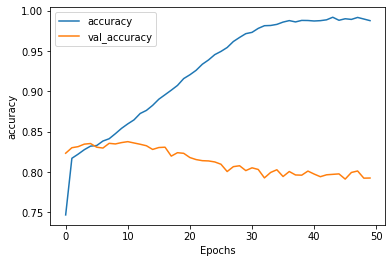

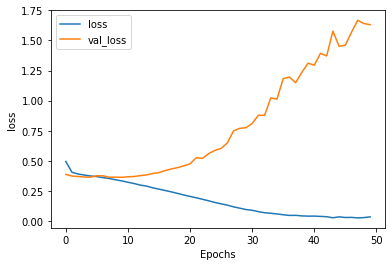

In [16]:
plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')